In [1]:
#%reset 
# import libraries
import sympy as sym
import numpy as np
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

#sym.init_printing()
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib.animation as ani
%matplotlib inline

# Some inital variables for the model

In [2]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
m = ConcreteModel() # create model using pyomo
N = 100 # number of nodes (much like samples used between a certain time period)
hm=0.9/N # Scaling factor for time-step
m.N = RangeSet(N) 
m.damping=20

mass_b=2 # Mass of the base
mass_l=1 # Mass of the links
len_b=0.25 # Length of the base
m.l_min=0.2 # Links min length
m.l_max=len_b # Links max length
m.F_max=16000 # Maximum force that can be applied
m.t_max=1200 # Maximum torque
m.w_max=4400 # Max angular velocity (omega)
m.dl_max=300
m.distance=15

print('Yeet')

Yeet


# Set up the EoM

In [3]:
# create symbolic variables
g = sym.symbols('g')

mb = sym.symbols('m_{body}') # mass
ml_Left, ml_Right = sym.symbols(['m_{legL}','m_{legR}']) # mass

lb = sym.symbols('l_{body}') # length
ll_Left, ll_Right = sym.symbols(['l_{legL}','l_{legR}'])

Inb = sym.symbols('I_{body}') # moment of intertia
Inl_Left, Inl_Right = sym.symbols(['I_{legL}','I_{legR}']) # moment of intertia

x,z,thl_Left,r_Left = sym.symbols(['x','z','\\theta_{legL}','r_{L}'])
thl_Right,r_Right = sym.symbols(['\\theta_{legR}','r_{R}'])

dx,dz,dthl_Left,dr_Left = sym.symbols(['\dot{x}','\dot{z}','\dot{\\theta}_{legL}','\dot{r}_{L}'])
dthl_Right, dr_Right = sym.symbols(['\dot{\\theta}_{legR}','\dot{r}_{R}']) 

ddx,ddz,ddthl_Left,ddr_Left = sym.symbols(['\ddot{x}','\ddot{z}','\ddot{\\theta}_{legL}','\ddot{r}_{R}'])
ddthl_Right, ddr_Right = sym.symbols(['\ddot{\\theta}_{legR}','\ddot{r}_{R}'])

q = sym.Matrix([[x],[z],[thl_Left],[thl_Right],[r_Left],[r_Right]])
dq = sym.Matrix([[dx],[dz],[dthl_Left],[dthl_Right],[dr_Left],[dr_Right]])
ddq = sym.Matrix([[ddx],[ddz],[ddthl_Left],[ddthl_Right],[ddr_Left],[ddr_Right]])

# forces
F_Left,tau_Left,GRFx_Left,GRFz_Left = sym.symbols(['F_{L}','\\tau_{L}','G_{xL}','G_{zL}'])
F_Right,tau_Right,GRFx_Right,GRFz_Right = sym.symbols(['F_{R}','\\tau_{R}','G_{xR}','G_{zR}'])


# STEP 1: position vector (COM of each link), as well as other required positions. 
rb = sym.Matrix([[x],
                [z]])

rl_Left = sym.Matrix([[x + (0.5*r_Left)*sym.cos(thl_Left)],
                 [z - (0.5*r_Left)*sym.sin(thl_Left)]])
rl_Right = sym.Matrix([[x + (0.5*r_Right)*sym.cos(thl_Right)],
                 [z - (0.5*r_Right)*sym.sin(thl_Right)]])


footx_Left = sym.Matrix([x + r_Left*sym.cos(thl_Left)])
footz_Left = sym.Matrix([z - r_Left*sym.sin(thl_Left)]) 
footz_Left = footz_Left[0].simplify()
foot_pos_Left = sym.Matrix([[footx_Left],[0],[footz_Left]])

footx_Right = sym.Matrix([x + r_Right*sym.cos(thl_Right)])
footz_Right = sym.Matrix([z - r_Right*sym.sin(thl_Right)]) 
footz_Right = footz_Right[0].simplify()
foot_pos_Right = sym.Matrix([[footx_Right],[0],[footz_Right]])


# STEP 2: generate expressions for the system space velocities from the jacobians
# the Jacobians
Jb = rb.jacobian(q)
Jl_Left = rl_Left.jacobian(q)
Jl_Right = rl_Right.jacobian(q)

vb = Jb*dq
vl_Left = Jl_Left*dq
vl_Right = Jl_Right*dq

footdx_Left = footx_Left.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
footdx_Left = footdx_Left[0].simplify()
footdx_Right = footx_Right.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
footdx_Right = footdx_Right[0].simplify()


# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb]]) # Mass matrix of body
Ml_Left = sym.Matrix([[ml_Left,ml_Left]]) # Mass matrix of leg(s)
Ml_Right = sym.Matrix([[ml_Right,ml_Right]]) # Mass matrix of leg(s)

Ib = sym.Matrix([[Inb]]) # Inertia matrix of body
Il_Left = sym.Matrix([[Inl_Left]]) # Inertia matrix of leg(s)
Il_Right = sym.Matrix([[Inl_Right]]) # Inertia matrix of leg(s)

Wl_Left = sym.Matrix([[dthl_Left]]) # Angular volocity of left-leg
Wl_Right = sym.Matrix([[dthl_Right]]) # Angular volocity of right-leg

# linear kinetic energy:
T1 = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) #+ 0.5*Ml_Left*sym.matrix_multiply_elementwise(vl_Left,vl_Left) + 0.5*Ml_Right*sym.matrix_multiply_elementwise(vl_Right,vl_Right)
# angular kinetic energy:
# this should be a 3*3 matrix of MOI and a vector of angular vel... w'*MOI*w
T2 =  0.5*Il_Left*sym.matrix_multiply_elementwise(Wl_Left,Wl_Left) + 0.5*Il_Right*sym.matrix_multiply_elementwise(Wl_Right,Wl_Right) 

T = sym.Matrix([T1[0]])+sym.Matrix([T2[0]])
# potential energy
V = mb*g*rb[1] + ml_Left*g*rl_Left[1] + ml_Right*g*rl_Right[1]


M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

C  = sym.zeros(len(q),len(q))                                                         
for i in range(len(q)):                                             
    for j in range(len(q)):
        for n in range(len(q)):
            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)                                         
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);       

J_Left = foot_pos_Left.jacobian(q)
GRF_l_Left = J_Left.transpose()*sym.Matrix([[GRFx_Left],[0],[GRFz_Left]])
Jl_Right = foot_pos_Right.jacobian(q)
GRF_l_Right = Jl_Right.transpose()*sym.Matrix([[GRFx_Right],[0],[GRFz_Right]])

Q = sym.zeros(len(q),1)
Q[0]=0                           #X
Q[1]=0                           #Z
Q[2]=tau_Left                    #thl_Right
Q[3]=tau_Right                   #thl_Left
Q[4]=F_Left-dr_Left*m.damping    #r_Left
Q[5]=F_Right-dr_Right*m.damping  #r_Right
           
EOM = M*ddq + C*dq + G - Q - GRF_l_Left - GRF_l_Right

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()

# Lambdify

In [4]:
# Lambdify
func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml_Left,ml_Right,lb,ll_Left,ll_Right,Inb,Inl_Left,Inl_Right,
            x,z,thl_Left,thl_Right,r_Left,r_Right,
            dx,dz,dthl_Left,dthl_Right,dr_Left,dr_Right,
            ddx,ddz,ddthl_Left,ddthl_Right,ddr_Left,ddr_Right,
            F_Left,tau_Left,GRFx_Left,GRFz_Left,
            F_Right,tau_Right,GRFx_Right,GRFz_Right]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_z = sym.lambdify(sym_list,EOMs[1],modules = [func_map]) # Should be the z-direction but fixing this will take effort
lambEOM_thl_Left = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_thl_Right = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_r_Left = sym.lambdify(sym_list,EOMs[4],modules = [func_map])
lambEOM_r_Right = sym.lambdify(sym_list,EOMs[5],modules = [func_map])

lamb_footz_Left = sym.lambdify(sym_list,footz_Left,modules = [func_map])
lamb_footdx_Left = sym.lambdify(sym_list,footdx_Left,modules = [func_map])
lamb_footz_Right = sym.lambdify(sym_list,footz_Right,modules = [func_map])
lamb_footdx_Right = sym.lambdify(sym_list,footdx_Right,modules = [func_map])

# Variables and parameters for the model

In [5]:
# Variables-----------------------------------------------------------------------------------------------------------------
cN = 3
m.cN =RangeSet(cN)

links = [('body',1),('leg',1)]
m.L = Set(dimen=2, initialize=links)

DOFs = ['x','z','theta_l_Left','theta_l_Right','r_Left','r_Right'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# system coordinates
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

m.tt = Var(m.N, m.cN)
m.tt0 = Var(m.N)


m.h = Var(m.N, bounds =(0.1,2.0))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]


# PARAMETERS-----------------------------------------------------------------------------------------------------------------
m.g = Param(initialize = 9.81)
pi=sym.pi

m.mb = Param(initialize = mass_b)
m.ml_Left = Param(initialize = mass_l)
m.ml_Right = Param(initialize = mass_l)

m.lb = Param(initialize = 0.2)
m.ll_Left = Param(initialize = len_b)
m.ll_Right = Param(initialize = len_b)

m.Inb = Param(initialize = m.mb.value*m.lb.value**2/12)   
m.Inl_Left = Param(initialize = m.ml_Left.value*m.lb.value**2/12)  ##############################m.ml.value*m.q[m.n,m.cN,'r']**2/12
m.Inl_Right = Param(initialize = m.ml_Right.value*m.lb.value**2/12)

mbody = m.mb.value + m.ml_Left.value + m.ml_Right.value
BW = mbody*m.g.value

In [6]:
def ContConstraint_p (m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)

def ContConstraint_v (m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)

def ContConstraint_tt (m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)

In [7]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)

def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)

def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)

In [8]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['X', 'Z','THETA1']
m.WDOF = Set(initialize=WDOFs) #change the coordinates
m.GRF_Left = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,None)) # should bound it to 10*m_robot*g
m.GRF_Right = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,None)) # should bound it to 10*m_robot*g
m.eps = Param(initialize=1000.0, mutable=True)
m.mu = Param(initialize =1.00)

# Stuff to do with feet

In [9]:
# SLACK VARIABLES
m.a_contact_Left   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_Left   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_Left  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_Left  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_Left    = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_Left    = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_Left    = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_Left    = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_Left       = Var(m.N, m.cN, bounds = (0.0,None))
######################################################################################################
m.a_contact_Right  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_Right  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_Right = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_Right = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_Right   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_Right   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_Right   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_Right   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_Right      = Var(m.N, m.cN, bounds = (0.0,None))


# CONTACT-----------------------------------------------------------------------------------------------------------------------------------------
def def_a_contact_Left(m,n,c):   
        var_list = [m.g,m.mb,m.ml_Left,m.ml_Right,
                    m.lb,m.ll_Left,m.ll_Right,
                    m.Inb,m.Inl_Left,m.Inl_Right,
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_l_Left'],m.q[n,c,'theta_l_Right'],m.q[n,c,'r_Left'],m.q[n,c,'r_Right'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_l_Left'],m.dq[n,c,'theta_l_Right'],m.dq[n,c,'r_Left'],m.dq[n,c,'r_Right'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_l_Left'],m.ddq[n,c,'theta_l_Right'],m.ddq[n,c,'r_Left'],m.ddq[n,c,'r_Right'],
                    0,0,0,0,
                    0,0,0,0]
        return m.a_contact_Left[n,c] == lamb_footz_Left(*var_list)
m.def_a_contact_Left = Constraint(m.N, m.cN, rule = def_a_contact_Left)
def def_b_contact_Left(m,n,c):   
    return m.b_contact_Left[n,c] == m.GRF_Left[n,c,'Z','ps']
m.def_b_contact_Left = Constraint(m.N, m.cN, rule = def_b_contact_Left)
#######################################################################################################
def def_a_contact_Right(m,n,c):   
        var_list = [m.g,m.mb,m.ml_Left,m.ml_Right,
                    m.lb,m.ll_Left,m.ll_Right,
                    m.Inb,m.Inl_Left,m.Inl_Right,
                    m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_l_Left'],m.q[n,c,'theta_l_Right'],m.q[n,c,'r_Left'],m.q[n,c,'r_Right'],
                    m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_l_Left'],m.dq[n,c,'theta_l_Right'],m.dq[n,c,'r_Left'],m.dq[n,c,'r_Right'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_l_Left'],m.ddq[n,c,'theta_l_Right'],m.ddq[n,c,'r_Left'],m.ddq[n,c,'r_Right'],
                    0,0,0,0,
                    0,0,0,0]
        return m.a_contact_Right[n,c] == lamb_footz_Right(*var_list)
m.def_a_contact_Right = Constraint(m.N, m.cN, rule = def_a_contact_Right)
def def_b_contact_Right(m,n,c):   
    return m.b_contact_Right[n,c] == m.GRF_Right[n,c,'Z','ps']
m.def_b_contact_Right = Constraint(m.N, m.cN, rule = def_b_contact_Right)


# FRICTION CONE------------------------------------------------------------------------------------------------------------------------------------
def def_a_friction_Left(m,n,c):   
    return m.a_friction_Left[n,c] == m.mu*m.GRF_Left[n,c,'Z','ps'] - (m.GRF_Left[n,c,'X','ps'] + m.GRF_Left[n,c,'X','ng'])
m.def_a_friction_Left = Constraint(m.N, m.cN, rule = def_a_friction_Left)
def def_b_friction_Left(m,n,c):   
    return m.b_friction_Left[n,c] == m.gamma_Left[n,c]
m.def_b_friction_Left = Constraint(m.N, m.cN, rule = def_b_friction_Left)
#########################################################################################################
def def_a_friction_Right(m,n,c):   
    return m.a_friction_Right[n,c] == m.mu*m.GRF_Right[n,c,'Z','ps'] - (m.GRF_Right[n,c,'X','ps'] + m.GRF_Right[n,c,'X','ng'])
m.def_a_friction_Right = Constraint(m.N, m.cN, rule = def_a_friction_Right)
def def_b_friction_Right(m,n,c):   
    return m.b_friction_Right[n,c] == m.gamma_Right[n,c]
m.def_b_friction_Right = Constraint(m.N, m.cN, rule = def_b_friction_Right)


#------------------------------------------------------------------------------------------------------------------------------------------------------
def def_contact_Left_pr(m,n):
    a_contact_Left_pr = m.a_contact_Left[n,1] + m.a_contact_Left[n,2] + m.a_contact_Left[n,3] 
    b_contact_Left_pr = m.b_contact_Left[n,1] + m.b_contact_Left[n,2] + m.b_contact_Left[n,3]  
    return a_contact_Left_pr*b_contact_Left_pr <= m.eps
m.def_contact_Left_pr = Constraint(m.N, rule = def_contact_Left_pr)

def def_friction_Left_pr(m,n):
    a_friction_Left_pr = m.a_friction_Left[n,1] + m.a_friction_Left[n,2] + m.a_friction_Left[n,3] 
    b_friction_Left_pr = m.b_friction_Left[n,1] + m.b_friction_Left[n,2] + m.b_friction_Left[n,3]  
    return a_friction_Left_pr*b_friction_Left_pr <= m.eps
m.def_friction_Left_pr = Constraint(m.N, rule = def_friction_Left_pr)

def def_slip_p_Left_pr(m,n):
    a_slip_p_Left_pr = m.a_slip_p_Left[n,1] + m.a_slip_p_Left[n,2] + m.a_slip_p_Left[n,3] 
    b_slip_p_Left_pr = m.b_slip_p_Left[n,1] + m.b_slip_p_Left[n,2] + m.b_slip_p_Left[n,3]  
    return a_slip_p_Left_pr*b_slip_p_Left_pr <= m.eps
m.def_slip_p_Left_pr = Constraint(m.N, rule = def_slip_p_Left_pr)

def def_slip_n_Left_pr(m,n):
    a_slip_n_Left_pr = m.a_slip_n_Left[n,1] + m.a_slip_n_Left[n,2] + m.a_slip_n_Left[n,3] 
    b_slip_n_Left_pr = m.b_slip_n_Left[n,1] + m.b_slip_n_Left[n,2] + m.b_slip_n_Left[n,3]  
    return a_slip_n_Left_pr*b_slip_n_Left_pr <= m.eps
m.def_slip_n_Left_pr = Constraint(m.N, rule = def_slip_n_Left_pr)
###########################################################################################
def def_contact_Right_pr(m,n):
    a_contact_Right_pr = m.a_contact_Right[n,1] + m.a_contact_Right[n,2] + m.a_contact_Right[n,3] 
    b_contact_Right_pr = m.b_contact_Right[n,1] + m.b_contact_Right[n,2] + m.b_contact_Right[n,3]  
    return a_contact_Right_pr*b_contact_Right_pr <= m.eps
m.def_contact_Right_pr = Constraint(m.N, rule = def_contact_Right_pr)

def def_friction_Right_pr(m,n):
    a_friction_Right_pr = m.a_friction_Right[n,1] + m.a_friction_Right[n,2] + m.a_friction_Right[n,3] 
    b_friction_Right_pr = m.b_friction_Right[n,1] + m.b_friction_Right[n,2] + m.b_friction_Right[n,3]  
    return a_friction_Right_pr*b_friction_Right_pr <= m.eps
m.def_friction_Right_pr = Constraint(m.N, rule = def_friction_Right_pr)

def def_slip_p_Right_pr(m,n):
    a_slip_p_Right_pr = m.a_slip_p_Right[n,1] + m.a_slip_p_Right[n,2] + m.a_slip_p_Right[n,3] 
    b_slip_p_Right_pr = m.b_slip_p_Right[n,1] + m.b_slip_p_Right[n,2] + m.b_slip_p_Right[n,3]  
    return a_slip_p_Right_pr*b_slip_p_Right_pr <= m.eps
m.def_slip_p_Right_pr = Constraint(m.N, rule = def_slip_p_Right_pr)

def def_slip_n_Right_pr(m,n):
    a_slip_n_Right_pr = m.a_slip_n_Right[n,1] + m.a_slip_n_Right[n,2] + m.a_slip_n_Right[n,3] 
    b_slip_n_Right_pr = m.b_slip_n_Right[n,1] + m.b_slip_n_Right[n,2] + m.b_slip_n_Right[n,3]  
    return a_slip_n_Right_pr*b_slip_n_Right_pr <= m.eps
m.def_slip_n_Right_pr = Constraint(m.N, rule = def_slip_n_Right_pr)

# Motor model

In [10]:
m.tau_a_Left = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip
m.F_a_Left = Var(m.N, bounds = (-m.F_max,m.F_max)) # actuator prismatic force

def def_hip_motor_model_p_Left(m,n):
    return  m.tau_a_Left[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_l_Left'])
m.def_hip_motor_model_p_1_Left = Constraint(m.N, rule = def_hip_motor_model_p_Left)
def def_hip_motor_model_n_Left(m,n):
    return  m.tau_a_Left[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_l_Left'])
m.def_hip_motor_model_n_Left = Constraint(m.N, rule = def_hip_motor_model_n_Left)

#########################################################################################

m.tau_a_Right = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip
m.F_a_Right = Var(m.N, bounds = (-m.F_max,m.F_max)) # actuator prismatic force

def def_hip_motor_model_p_Right(m,n):
    return  m.tau_a_Right[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_l_Right'])
m.def_hip_motor_model_p_Right = Constraint(m.N, rule = def_hip_motor_model_p_Right)
def def_hip_motor_model_n_Right(m,n):
    return  m.tau_a_Right[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_l_Right'])
m.def_hip_motor_model_n_Right = Constraint(m.N, rule = def_hip_motor_model_n_Right)

# EoM constraints


In [11]:
S=1.0 #BW/m.mTot    #Scaling factor, I avoid scaling the problem, others seem to think it works....

def EOM_x(m,n,c):
    F_in_Left    = S*(m.F_a_Left[n])
    tau_in_Left  = S*(m.tau_a_Left[n])
    Gx_in_Left   = S*(m.GRF_Left[n,c,'X','ps']-m.GRF_Left[n,c,'X','ng'])
    Gz_in_Left   = S*(m.GRF_Left[n,c,'Z','ps'])
    
    F_in_Right   = S*(m.F_a_Right[n])
    tau_in_Right = S*(m.tau_a_Right[n])
    Gx_in_Right  = S*(m.GRF_Right[n,c,'X','ps']-m.GRF_Right[n,c,'X','ng'])
    Gz_in_Right  = S*(m.GRF_Right[n,c,'Z','ps'])
    
    
    var_list = [m.g,m.mb,m.ml_Left,m.ml_Right,
                m.lb,m.ll_Left,m.ll_Right,
                m.Inb,m.Inl_Left,m.Inl_Right,
                m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_l_Left'],m.q[n,c,'theta_l_Right'],m.q[n,c,'r_Left'],m.q[n,c,'r_Right'],
                m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_l_Left'],m.dq[n,c,'theta_l_Right'],m.dq[n,c,'r_Left'],m.dq[n,c,'r_Right'],
                m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_l_Left'],m.ddq[n,c,'theta_l_Right'],m.ddq[n,c,'r_Left'],m.ddq[n,c,'r_Right'],
                F_in_Left,tau_in_Left,Gx_in_Left,Gz_in_Left,
                F_in_Right,tau_in_Right,Gx_in_Right,Gz_in_Right]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.cN, rule = EOM_x)

def EOM_z(m,n,c):   
    F_in_Left    = S*(m.F_a_Left[n])
    tau_in_Left  = S*(m.tau_a_Left[n])
    Gx_in_Left   = S*(m.GRF_Left[n,c,'X','ps']-m.GRF_Left[n,c,'X','ng'])
    Gz_in_Left   = S*(m.GRF_Left[n,c,'Z','ps'])
    
    F_in_Right   = S*(m.F_a_Right[n])
    tau_in_Right = S*(m.tau_a_Right[n])
    Gx_in_Right  = S*(m.GRF_Right[n,c,'X','ps']-m.GRF_Right[n,c,'X','ng'])
    Gz_in_Right  = S*(m.GRF_Right[n,c,'Z','ps'])    
    
    var_list = [m.g,m.mb,m.ml_Left,m.ml_Right,
                m.lb,m.ll_Left,m.ll_Right,
                m.Inb,m.Inl_Left,m.Inl_Right,
                m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_l_Left'],m.q[n,c,'theta_l_Right'],m.q[n,c,'r_Left'],m.q[n,c,'r_Right'],
                m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_l_Left'],m.dq[n,c,'theta_l_Right'],m.dq[n,c,'r_Left'],m.dq[n,c,'r_Right'],
                m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_l_Left'],m.ddq[n,c,'theta_l_Right'],m.ddq[n,c,'r_Left'],m.ddq[n,c,'r_Right'],
                F_in_Left,tau_in_Left,Gx_in_Left,Gz_in_Left,
                F_in_Right,tau_in_Right,Gx_in_Right,Gz_in_Right]
    return lambEOM_z(*var_list) == 0
m.EOM_z = Constraint(m.N, m.cN, rule = EOM_z)

def EOM_thl_Left(m,n,c):
    F_in_Left    = S*(m.F_a_Left[n])
    tau_in_Left  = S*(m.tau_a_Left[n])
    Gx_in_Left   = S*(m.GRF_Left[n,c,'X','ps']-m.GRF_Left[n,c,'X','ng'])
    Gz_in_Left   = S*(m.GRF_Left[n,c,'Z','ps'])
    
    F_in_Right   = S*(m.F_a_Right[n])
    tau_in_Right = S*(m.tau_a_Right[n])
    Gx_in_Right  = S*(m.GRF_Right[n,c,'X','ps']-m.GRF_Right[n,c,'X','ng'])
    Gz_in_Right  = S*(m.GRF_Right[n,c,'Z','ps']) 
    
    var_list = [m.g,m.mb,m.ml_Left,m.ml_Right,
                m.lb,m.ll_Left,m.ll_Right,
                m.Inb,m.Inl_Left,m.Inl_Right,
                m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_l_Left'],m.q[n,c,'theta_l_Right'],m.q[n,c,'r_Left'],m.q[n,c,'r_Right'],
                m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_l_Left'],m.dq[n,c,'theta_l_Right'],m.dq[n,c,'r_Left'],m.dq[n,c,'r_Right'],
                m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_l_Left'],m.ddq[n,c,'theta_l_Right'],m.ddq[n,c,'r_Left'],m.ddq[n,c,'r_Right'],
                F_in_Left,tau_in_Left,Gx_in_Left,Gz_in_Left,
                F_in_Right,tau_in_Right,Gx_in_Right,Gz_in_Right]
    return lambEOM_thl_Left(*var_list) == 0
m.EOM_thl_Left = Constraint(m.N, m.cN, rule = EOM_thl_Left)

def EOM_thl_Right(m,n,c):
    F_in_Left    = S*(m.F_a_Left[n])
    tau_in_Left  = S*(m.tau_a_Left[n])
    Gx_in_Left   = S*(m.GRF_Left[n,c,'X','ps']-m.GRF_Left[n,c,'X','ng'])
    Gz_in_Left   = S*(m.GRF_Left[n,c,'Z','ps'])
    
    F_in_Right   = S*(m.F_a_Right[n])
    tau_in_Right = S*(m.tau_a_Right[n])
    Gx_in_Right  = S*(m.GRF_Right[n,c,'X','ps']-m.GRF_Right[n,c,'X','ng'])
    Gz_in_Right  = S*(m.GRF_Right[n,c,'Z','ps']) 
    
    var_list = [m.g,m.mb,m.ml_Left,m.ml_Right,
                m.lb,m.ll_Left,m.ll_Right,
                m.Inb,m.Inl_Left,m.Inl_Right,
                m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_l_Left'],m.q[n,c,'theta_l_Right'],m.q[n,c,'r_Left'],m.q[n,c,'r_Right'],
                m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_l_Left'],m.dq[n,c,'theta_l_Right'],m.dq[n,c,'r_Left'],m.dq[n,c,'r_Right'],
                m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_l_Left'],m.ddq[n,c,'theta_l_Right'],m.ddq[n,c,'r_Left'],m.ddq[n,c,'r_Right'],
                F_in_Left,tau_in_Left,Gx_in_Left,Gz_in_Left,
                F_in_Right,tau_in_Right,Gx_in_Right,Gz_in_Right]
    return lambEOM_thl_Right(*var_list) == 0
m.EOM_thl_Right = Constraint(m.N, m.cN, rule = EOM_thl_Right)

def EOM_r_Left(m,n,c):
    F_in_Left    = S*(m.F_a_Left[n])
    tau_in_Left  = S*(m.tau_a_Left[n])
    Gx_in_Left   = S*(m.GRF_Left[n,c,'X','ps']-m.GRF_Left[n,c,'X','ng'])
    Gz_in_Left   = S*(m.GRF_Left[n,c,'Z','ps'])
    
    F_in_Right   = S*(m.F_a_Right[n])
    tau_in_Right = S*(m.tau_a_Right[n])
    Gx_in_Right  = S*(m.GRF_Right[n,c,'X','ps']-m.GRF_Right[n,c,'X','ng'])
    Gz_in_Right  = S*(m.GRF_Right[n,c,'Z','ps']) 
    
    var_list = [m.g,m.mb,m.ml_Left,m.ml_Right,
                m.lb,m.ll_Left,m.ll_Right,
                m.Inb,m.Inl_Left,m.Inl_Right,
                m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_l_Left'],m.q[n,c,'theta_l_Right'],m.q[n,c,'r_Left'],m.q[n,c,'r_Right'],
                m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_l_Left'],m.dq[n,c,'theta_l_Right'],m.dq[n,c,'r_Left'],m.dq[n,c,'r_Right'],
                m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_l_Left'],m.ddq[n,c,'theta_l_Right'],m.ddq[n,c,'r_Left'],m.ddq[n,c,'r_Right'],
                F_in_Left,tau_in_Left,Gx_in_Left,Gz_in_Left,
                F_in_Right,tau_in_Right,Gx_in_Right,Gz_in_Right]
    return lambEOM_r_Left(*var_list) == 0
m.EOM_r_Left = Constraint(m.N, m.cN, rule = EOM_r_Left)

def EOM_r_Right(m,n,c):
    F_in_Left    = S*(m.F_a_Left[n])
    tau_in_Left  = S*(m.tau_a_Left[n])
    Gx_in_Left   = S*(m.GRF_Left[n,c,'X','ps']-m.GRF_Left[n,c,'X','ng'])
    Gz_in_Left   = S*(m.GRF_Left[n,c,'Z','ps'])
    
    F_in_Right   = S*(m.F_a_Right[n])
    tau_in_Right = S*(m.tau_a_Right[n])
    Gx_in_Right  = S*(m.GRF_Right[n,c,'X','ps']-m.GRF_Right[n,c,'X','ng'])
    Gz_in_Right  = S*(m.GRF_Right[n,c,'Z','ps']) 
    
    var_list = [m.g,m.mb,m.ml_Left,m.ml_Right,
                m.lb,m.ll_Left,m.ll_Right,
                m.Inb,m.Inl_Left,m.Inl_Right,
                m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_l_Left'],m.q[n,c,'theta_l_Right'],m.q[n,c,'r_Left'],m.q[n,c,'r_Right'],
                m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_l_Left'],m.dq[n,c,'theta_l_Right'],m.dq[n,c,'r_Left'],m.dq[n,c,'r_Right'],
                m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_l_Left'],m.ddq[n,c,'theta_l_Right'],m.ddq[n,c,'r_Left'],m.ddq[n,c,'r_Right'],
                F_in_Left,tau_in_Left,Gx_in_Left,Gz_in_Left,
                F_in_Right,tau_in_Right,Gx_in_Right,Gz_in_Right]
    return lambEOM_r_Right(*var_list) == 0
m.EOM_r_Right = Constraint(m.N, m.cN, rule = EOM_r_Right)

# Bounds

In [12]:
def setxBounds(m,n):
    return (-1.0, m.q0[n,'x'], m.distance+1)
m.setxBounds = Constraint(m.N, rule=setxBounds)
def setzBounds(m,n):
    return (0.0, m.q0[n,'z'], 5)
m.setzBounds = Constraint(m.N, rule=setzBounds)
def setthlBounds_Left(m,n):
    return (-3.14, m.q0[n,'theta_l_Left'], 3.14)
m.setthlBounds_Left = Constraint(m.N, rule=setthlBounds_Left)
def setthlBounds_Right(m,n):
    return (-3.14, m.q0[n,'theta_l_Right'], 3.14)
m.setthlBounds_Right = Constraint(m.N, rule=setthlBounds_Right)
def setrBounds_Left(m,n):
    return (m.l_min, m.q0[n,'r_Left'], m.ll_Left)
m.setrBounds_Left = Constraint(m.N, rule=setrBounds_Left)
def setrBounds_Right(m,n):
    return (m.l_min, m.q0[n,'r_Right'], m.ll_Right)
m.setrBounds_Right = Constraint(m.N, rule=setrBounds_Right)

def setdxBounds(m,n):
    return (-10, m.dq0[n,'x'],10)
m.setdxBounds = Constraint(m.N, rule=setdxBounds)
def setdzBounds(m,n):
    return (-10, m.dq0[n,'z'],10)
m.setdzBounds = Constraint(m.N, rule=setdzBounds)
def setthlBounds_Left(m,n):
    return (-m.w_max, m.dq0[n,'theta_l_Left'], m.w_max)
m.setdthlBounds_Left = Constraint(m.N, rule=setthlBounds_Left)
def setthlBounds_Right(m,n):
    return (-m.w_max, m.dq0[n,'theta_l_Right'], m.w_max)
m.setdthlBounds_Right = Constraint(m.N, rule=setthlBounds_Right)
def setrBounds_Left(m,n):
    return (-m.dl_max, m.dq0[n,'r_Left'],m.dl_max)
m.setdrBounds_Left = Constraint(m.N, rule=setrBounds_Left)
def setrBounds_Right(m,n):
    return (-m.dl_max, m.dq0[n,'r_Right'],m.dl_max)
m.setdrBounds_Right = Constraint(m.N, rule=setrBounds_Right)

# Assign random seed

In [13]:
R = 1.0
D = 5.0

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'x'].value = Domain[n-1] + np.random.uniform(-0.25,0.25)    
        m.q[n,c,'z'].value  = Range[n-1] + np.random.uniform(-0.25,0.25)
        m.q[n,c,'theta_l_Left'].value  = np.random.uniform(0.0,np.pi/2)
        m.q[n,c,'theta_l_Right'].value  = np.random.uniform(0.0,np.pi/2)
        m.q[n,c,'r_Left'].value  = np.random.uniform(0.0,0.5)
        m.q[n,c,'r_Right'].value  = np.random.uniform(0.0,0.5)
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value = 0.01
            m.ddq[n,c , dof].value = 0.01


        m.GRF_Left[n,c,'Z','ps'].value = 0.01
        m.GRF_Left[n,c,'X','ps'].value = 0.01 
        m.GRF_Left[n,c,'X','ng'].value = 0.01
        
        m.GRF_Right[n,c,'Z','ps'].value = 0.01
        m.GRF_Right[n,c,'X','ps'].value = 0.01 
        m.GRF_Right[n,c,'X','ng'].value = 0.01      

# End conditions

In [14]:
# constraints for steady-state 
m.q[1,1,'x'].value = 0.0
m.q[1,1,'x'].fixed = True
m.q[1,1,'z'].value = 0.5
m.q[1,1,'z'].fixed = True


m.dq[1,1,'z'].value = 0.0
m.dq[1,1,'z'].fixed = True

def finalX(m,n):
    if (n==N) :
        return m.q0[n,'x'] >= m.distance
    else:
        return Constraint.Skip
m.finalX = Constraint(m.N, rule = finalX)

def finalZ(m,n):
    if (n==N) :
        return m.q0[n,'z'] == m.q0[1,'z']
    else:
        return Constraint.Skip
m.finalZ = Constraint(m.N, rule = finalZ)


def finalthl_Left(m,n):
    if (n==N) :
        return m.q0[n,'theta_l_Left'] == m.q0[1,'theta_l_Left']
    else:
        return Constraint.Skip
m.finalthl_Left = Constraint(m.N, rule = finalthl_Left)


def finalthl_Right(m,n):
    if (n==N) :
        return m.q0[n,'theta_l_Right'] == m.q0[1,'theta_l_Right']
    else:
        return Constraint.Skip
m.finalthl_Right = Constraint(m.N, rule = finalthl_Right)

def finalr_Left(m,n):
    if (n==N) :
        return m.q0[n,'r_Left'] == m.q0[1,'r_Left']
    else:
        return Constraint.Skip
m.finalr_Left = Constraint(m.N, rule = finalr_Left)

def finalr_Right(m,n):
    if (n==N) :
        return m.q0[n,'r_Right'] == m.q0[1,'r_Right']
    else:
        return Constraint.Skip
m.finalr_Right = Constraint(m.N, rule = finalr_Right)

##################################################################

def finaldx(m,n):
    if (n==N) :
        return m.dq0[n,'x'] == m.dq0[1,'x']
    else:
        return Constraint.Skip
m.finaldx = Constraint(m.N, rule = finaldx)

def finaldz(m,n):
    if (n==N) :
        return m.dq0[n,'z'] == m.dq0[1,'z']
    else:
        return Constraint.Skip
m.finaldz = Constraint(m.N, rule = finaldz)

def finaldthl_Left(m,n):
    if (n==N) :
        return m.dq0[n,'theta_l_Left'] == m.dq0[1,'theta_l_Left']
    else:
        return Constraint.Skip
m.finaldthl_Left = Constraint(m.N, rule = finaldthl_Left)


def finaldthl_Right(m,n):
    if (n==N) :
        return m.dq0[n,'theta_l_Right'] == m.dq0[1,'theta_l_Right']
    else:
        return Constraint.Skip
m.finaldthl_Right = Constraint(m.N, rule = finaldthl_Right)

def finaldr_Left(m,n):
    if (n==N) :
        return m.dq0[n,'r_Left'] == m.dq0[1,'r_Left']
    else:
        return Constraint.Skip
m.finaldr_Left = Constraint(m.N, rule = finaldr_Left)

def finaldr_Right(m,n):
    if (n==N) :
        return m.dq0[n,'r_Right'] == m.dq0[1,'r_Right']
    else:
        return Constraint.Skip
m.finaldr_Right = Constraint(m.N, rule = finaldr_Right)

# Run the solver


In [15]:
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 0 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 120000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)

#solve once with obj=1
results = opt.solve(m, tee=True)

#def CostFun(m):
#    Ll = sum(((m.tauL_a[n]**2+m.FL_a[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
#    Rl = sum(((m.tauR_a[n]**2+m.FR_a[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
#    return Ll + Rl
#m.Cost = Objective(rule = CostFun)

#loop solve with proper objective
for i in range(0,4):
    print(m.eps.value)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

Ipopt 3.13.2: expect_infeasible_problem=yes
print_level=0
max_iter=30000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

1000.0
Ipopt 3.13.2: expect_infeasible_problem=yes
print_level=0
max_iter=30000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

100.0
Ipo

# Draw it


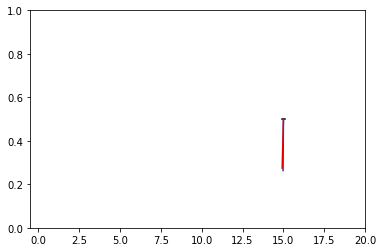

In [17]:
fig1, ax1 = plt.subplots(1,1) #create axes
#ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,20])
    ax.set_ylim([0,1])
    
    #plot body
    body_xb = m.q0[i,'x'].value - 0.5*m.lb
    body_yb = m.q0[i,'z'].value
    body_xf = m.q0[i,'x'].value + 0.5*m.lb
    body_yf = m.q0[i,'z'].value
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
    
    #plot leg 
    leg_xt_Left = m.q0[i,'x'].value 
    leg_yt_Left = m.q0[i,'z'].value 
    leg_xb_Left = m.q0[i,'x'].value + m.q0[i,'r_Left'].value*cos(m.q0[i,'theta_l_Left'].value)
    leg_yb_Left = m.q0[i,'z'].value - m.q0[i,'r_Left'].value*sin(m.q0[i,'theta_l_Left'].value)
    ax.plot([leg_xt_Left,leg_xb_Left],[leg_yt_Left,leg_yb_Left],color='xkcd:blue')
    
    #plot leg 
    leg_xt_Right = m.q0[i,'x'].value 
    leg_yt_Right = m.q0[i,'z'].value 
    leg_xb_Right = m.q0[i,'x'].value + m.q0[i,'r_Right'].value*cos(m.q0[i,'theta_l_Right'].value)
    leg_yb_Right = m.q0[i,'z'].value - m.q0[i,'r_Right'].value*sin(m.q0[i,'theta_l_Right'].value)
    ax.plot([leg_xt_Right,leg_xb_Right],[leg_yt_Right,leg_yb_Right],color='xkcd:red')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=False)

HTML(animate.to_jshtml())
#HTML(animate.to_html5_video()) 